<a href="https://colab.research.google.com/github/FlyPig23/CSE5526/blob/main/CSE_5526_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate a set of 100 data points by sampling the function h(x) = 0.5 + 0.4cos(2.5πx) with added uniform noise in the interval [-0.1, 0.1] and with x values taken randomly from a uniform distribution in the interval [0.0, 1.0].

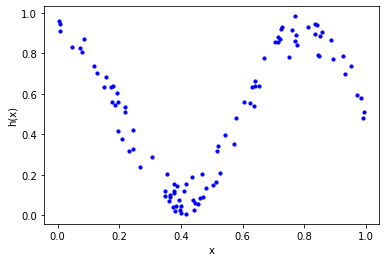

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fix random state for reproducibility if needed
# np.random.seed(0)

# Pick 100 x values randomly from a uniform distribution in the interval [0.0, 1.0]
x = np.random.uniform(0.0, 1.0, 100)
h = 0.5 + 0.4 * np.cos(2.5 * x * np.pi)

# Add noise uniformly in the interval [-0.1, 0.1]
noise = np.random.uniform(-0.1, 0.1, h.shape)
h = h + noise

data_array = np.array([x, h])
plt.scatter(data_array[0, :], data_array[1, :], s = 10, c = 'blue')
plt.xlabel('x')
plt.ylabel('h(x)')
plt.show()

Determine Gaussian centers by the K-means algorithm, and set the variance of each cluster according to the variance of the cluster. If a cluster contains only one sample point, use as its variance the mean variance of all the other clusters.

In [ ]:
# Implement the K-means algorithm
def kmeans(k, data_array):
  # Set stop flag
  stop = False

  # Choose a set of K cluster centers randomly from the input data array
  cluster_centers_x = np.random.choice(data_array[0, :], k)
  cluster_centers_h = 0.5 + 0.4 * np.cos(2.5 * cluster_centers_x * np.pi)
  cluster_centers = np.array([cluster_centers_x, cluster_centers_h])

  # Initialize the cluster label array
  clusters = np.zeros(data_array.shape[1])

  while not stop:
    for i in range(data_array.shape[1]):
      # Set an unbounded upper value for distance comparison
      min_distance = float('inf')
      # Calculate distances of current point to all cluster centers
      for j in range(cluster_centers.shape[1]):
        distance = np.sqrt((cluster_centers[0][j] - data_array[0][i]) ** 2 + (cluster_centers[1][j] - data_array[1][i]) ** 2)
        # Compare the distance to current minimum distance, then update classification if necessary
        if min_distance > distance:
          # If the distance is samller, update the minimum distance
          min_distance = distance
          # If the distance is samller, assign current point to current cluster center
          # Add 1 because range of j is (0, k-1)
          clusters[i] = j + 1
    
    # Update cluster centers, and store the results in a temporary new array
    new_cluster_centers = np.zeros(cluster_centers.shape)
    for i in range(new_cluster_centers.shape[1]): 
      sum_x = 0
      sum_h = 0
      count = 0
      for j in range(data_array.shape[1]):
        if clusters[j] == (i + 1):
          sum_x += data_array[0][j]
          sum_h += data_array[1][j]
          count += 1
      if count != 0:
        new_cluster_centers[0][i] = sum_x / count
        new_cluster_centers[1][i] = sum_h / count

      # Compare the new cluster centers to the original cluster centers, then decide whether to continue
      if np.array_equal(cluster_centers, new_cluster_centers):
        stop = True
      else:
        cluster_centers = new_cluster_centers

  return cluster_centers, clusters


# Calculate the WCSS (Within-Cluster Sum of Square)
def cost(data_array, cluster_centers, clusters):
  sum = 0
  for i in range(cluster_centers.shape[1]):
    for j in range(data_array.shape[1]):
      if clusters[j] == (i + 1):
        sum += ((cluster_centers[0][i] - data_array[0][j]) ** 2 + (cluster_centers[1][i] - data_array[1][j]) ** 2)
  return sum


# Use Elbow Method to choose a K value
def elbow_method(k_max, data_array):
  cost_list = []
  for k in range(1, k_max):
    cluster_centers, clusters = kmeans(k, data_array)
    # Add withn-cluster sum of square to the cost list
    cost_list.append(cost(data_array, cluster_centers, clusters))
  
  # Plot a line shows the relationship between cost and k
  sns.lineplot(x = range(1, k_max), y = cost_list, marker = 'o')
  plt.xlabel('K')
  plt.ylabel('Cost')
  plt.show()


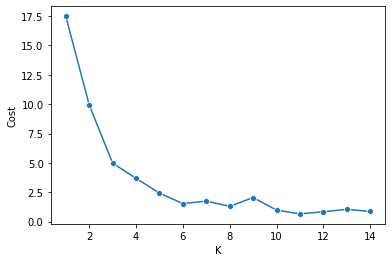

In [ ]:
# Set the maximum value of K, and run the Elbow Method
k_max = 15
elbow_method(k_max, data_array)

Implement the second layer of the RBF to predict the output from the projected input through the basis functions.

In [ ]:
def gaussian(k, cluster_centers, clusters):
  # Calculate Gaussian widths and Gaussian inputs
  variance_list = np.zeros((1, k))
  cluster_size = np.zeros((1, k))
  cluster_cost = np.zeros((1, k))
  gaussian_input = np.zeros((data_array.shape[1], k))
  fixed_gaussian_input = np.zeros((data_array.shape[1], k))

  for i in range(cluster_centers.shape[1]): 
    for j in range(data_array.shape[1]):
      if clusters[j] == (i + 1):
        cluster_cost[0][i] += ((cluster_centers[0][i] - data_array[0][j]) ** 2 + (cluster_centers[1][i] - data_array[1][j]) ** 2)
        cluster_size[0][i] += 1

  for i in range(cluster_centers.shape[1]):
    if cluster_size[0][i] != 0:
      variance_list[0][i] = np.float32((cluster_cost[0][i] / cluster_size[0][i]))
  
  for i in range(data_array.shape[1]): 
    for j in range(cluster_centers.shape[1]):
      if variance_list[0][j] != 0:
        gaussian_input[i][j] = np.exp(-((cluster_centers[0][j] - data_array[0][i]) ** 2 + (cluster_centers[1][j] - data_array[1][i]) ** 2) / (2 * variance_list[0][j]))
  
  # Compute the fixed variance
  max_distance = float('-inf')
  for i in range(cluster_centers.shape[1]):
    for j in range(cluster_centers.shape[1]):
      distance = np.sqrt((cluster_centers[0][i] - cluster_centers[0][j]) ** 2 + (cluster_centers[1][i] - cluster_centers[1][j]) ** 2)
      if max_distance < distance:
        max_distance = distance
  fixed_variance = (max_distance ** 2) / (2 * k)
  fixed_variance_list = np.full((1, k), fixed_variance)

  # Compute gaussian input with fixed variance
  for i in range(data_array.shape[1]): 
    for j in range(cluster_centers.shape[1]):
      fixed_gaussian_input[i][j] = np.exp(-((cluster_centers[0][j] - data_array[0][i]) ** 2 + (cluster_centers[1][j] - data_array[1][i]) ** 2) / (2 * fixed_variance_list[0][j]))
  
  return variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input

In [ ]:
import torch
from torch.autograd import Variable

# Define a learner class, decended from torch.nn.Module
# This class should have an initialization routine, as well as compute
# a forward result. The forward result should use torch layers that are 
# differentiable. This way PyTorch can automatically compute the gradient
# for the optimizer.
class linearRegression(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super(linearRegression, self).__init__()
    self.linear = torch.nn.Linear(input_size, output_size)

  def forward(self, x):
    out = self.linear(x)
    return out

In [ ]:
def LMS(k, learning_rate, gaussian_input):
  # Set input and output dimension
  input_dimension = k
  output_dimension = 1
  # Set maximum number of epochs
  epochs = 100

  # Create a model for the specific problem size (1 in, 1 out, bias true)
  model = linearRegression(input_dimension, output_dimension)
  # Set up the GPU if it is available.
  if torch.cuda.is_available():
      model.cuda()

  # Choose MSE loss as the loss function for linear regression
  criterion = torch.nn.MSELoss()
  # Create an optimizer that uses Stochastic Gradient Descent, and let it know about the model's parameters
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

  # Create a simple learning loop that runs batch mode over all of the datapoints (collecting gradients from all examples in the training set)
  for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(np.float32(gaussian_input)).cuda())
        labels = Variable(torch.from_numpy(np.float32(data_array[1,:].reshape(1, 100).T)).cuda())
    else:
        inputs = Variable(torch.from_numpy(np.float32(gaussian_input)))
        labels = Variable(torch.from_numpy(np.float32(data_array[1,:].reshape(1, 100).T)))
        
    # Clear gradient buffers because we don't want gradients from previous epoch to carry forward (no gradient accumulation)
    optimizer.zero_grad()

    # Get output from the model, given the inputs
    outputs = model(inputs)

    # Get loss for the predicted output
    # Note that "loss" for PyTorch is an object that has access to the model, so that it can create the gradients for the model
    loss = criterion(outputs, labels)

    # Get gradients w.r.t to parameters
    loss.backward()

    # Update parameters
    optimizer.step()

  print('epoch {}, loss {}'.format(epoch, loss.item()))
  
  # Get weights and bias
  tensors = []
  for param in model.parameters():
    tensors.append(param.data)

  weight = tensors[0]
  bias = tensors[1]

  return weight, bias

In [ ]:
def draw(k, weight, bias, variance_list):
  # Draw the graph
  x_predict = np.linspace(0, 1, 1000)
  h_predict = np.zeros((1000, k))
  h_predict_sum = np.zeros((1000, 1))
  for i in range(k):
    for j in range(x_predict.shape[0]): 
      if (variance_list[0][i] != 0):
        h_predict[j][i] += np.exp(-((x_predict[j] - cluster_centers[0][i]) ** 2) / (2 * variance_list[0][i]))  * weight[0][i]
    plt.plot(x_predict, h_predict[:, i], '--')

  for i in range(h_predict_sum.shape[0]):
    for j in range(k):
      h_predict_sum[i][0] += h_predict[i][j]
    h_predict_sum[i][0] += bias[0]
  # Draw the predicted function
  plt.plot(x_predict, h_predict_sum, 'b')

  # Draw the orignal data points
  plt.scatter(data_array[0, :], data_array[1, :], c = 'orange')

  # Draw the original function
  x_sample = np.linspace(0, 1, 1000)
  h_sample = 0.5 + 0.4 * np.cos(2.5 * x_sample * np.pi)
  plt.plot(x_sample, h_sample, 'g')

  plt.show()

Test with different variances.

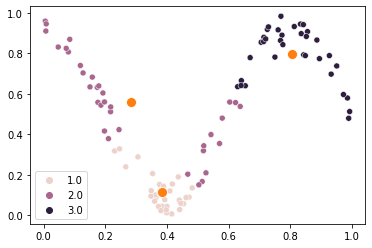

epoch 99, loss 0.10307043045759201


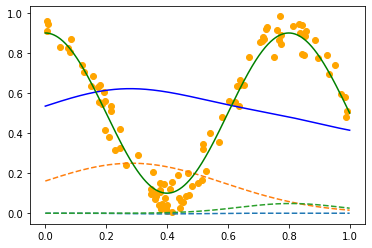

In [ ]:
# K = 3, learning rate = 0.01
k = 3
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

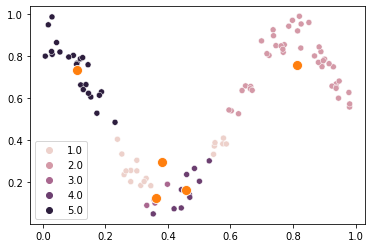

epoch 99, loss 0.017483917996287346


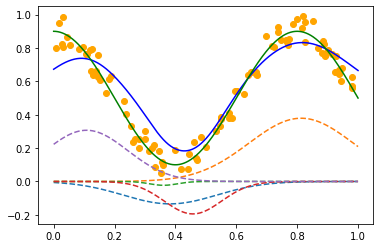

In [ ]:
# K = 5, learning rate = 0.01
k = 5
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

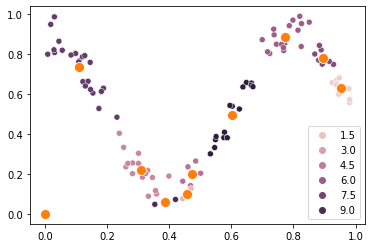

epoch 99, loss 0.040967024862766266


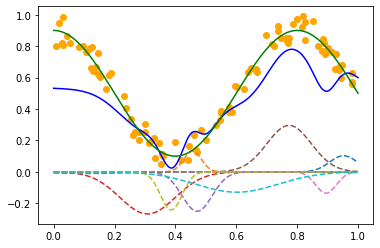

In [ ]:
# K = 10, learning rate = 0.01
k = 10
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

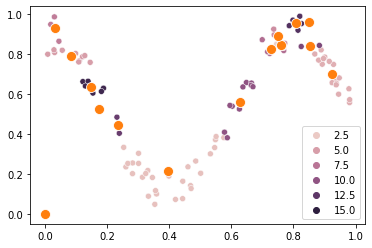

epoch 99, loss 0.03856312856078148


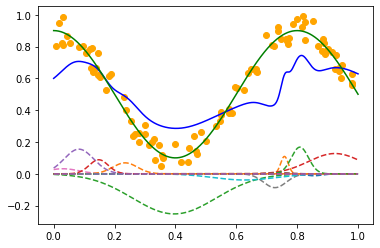

In [ ]:
# K = 15, learning rate = 0.01
k = 15
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

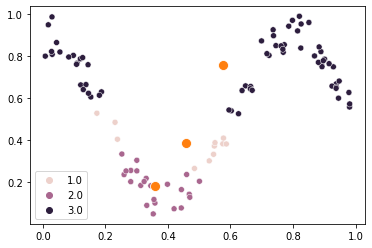

epoch 99, loss 0.025206053629517555


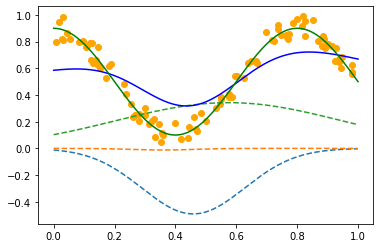

In [ ]:
# K = 3, learning rate = 0.02
k = 3
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

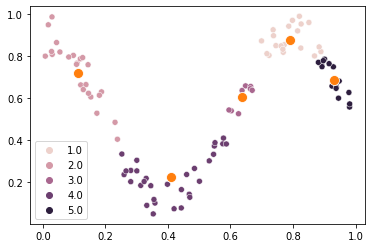

epoch 99, loss 0.024628590792417526


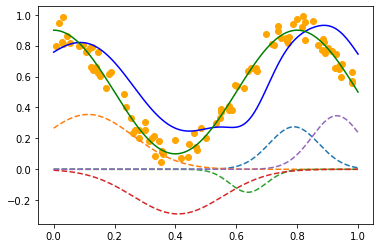

In [ ]:
# K = 5, learning rate = 0.02
k = 5
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

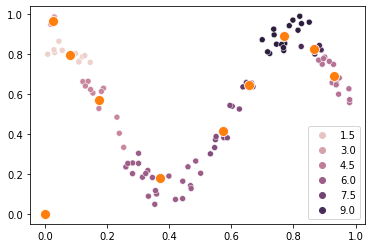

epoch 99, loss 0.034491848200559616


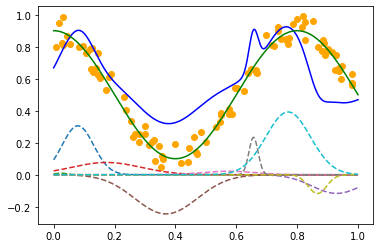

In [ ]:
# K = 10, learning rate = 0.02
k = 10
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

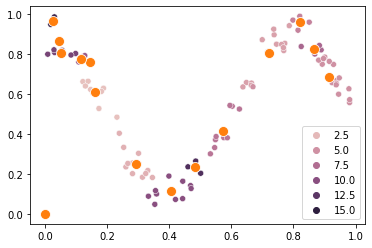

epoch 99, loss 0.033168379217386246


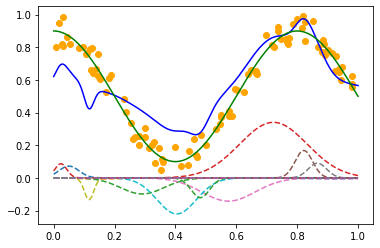

In [ ]:
# K = 15, learning rate = 0.02
k = 15
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

Comment on the dependence of the network performance on the number of bases:\
The network works better with 5 or 10 bases than with 3 or 15 bases. That might because 3 bases don't provide enough features, while 15 bases cause overfitting problem.\
Comment on the dependence of the choice of learning rate:\
The network works better with learning rate 0.02 than with 0.01. That might because higher learning rate increased learning efficiency when epoch number is fixed.\
Also, I found that when I use higher learning rate and proper base number, I could get better result. Here is the example.


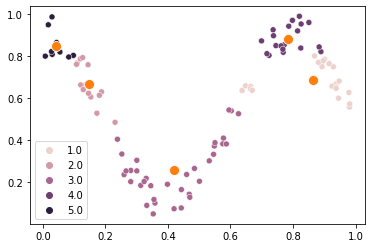

epoch 99, loss 0.008378233760595322


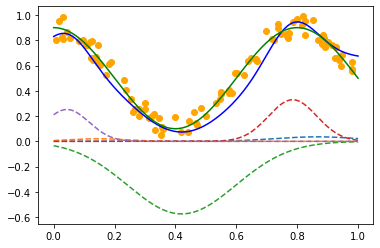

In [ ]:
# K = 5, learning rate = 0.5
k = 5
learning_rate = 0.5
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, gaussian_input)
draw(k, weight, bias, variance_list)

Test with fixed variance.

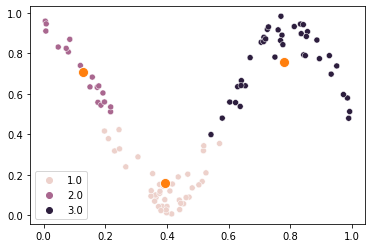

epoch 99, loss 0.04449380934238434


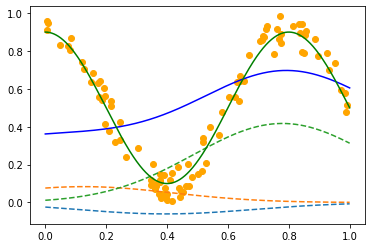

In [ ]:
# K = 3, learning rate = 0.01
k = 3
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

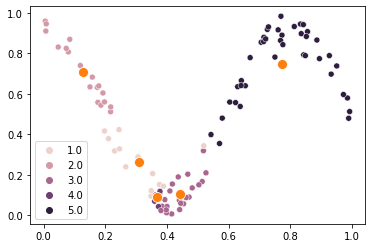

epoch 99, loss 0.05483200401067734


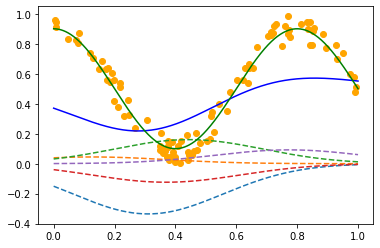

In [ ]:
# K = 5, learning rate = 0.01
k = 5
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

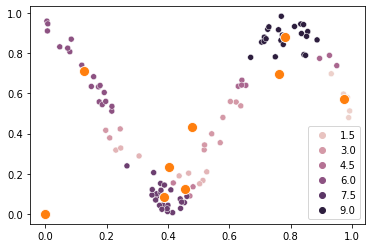

epoch 99, loss 0.05658651888370514


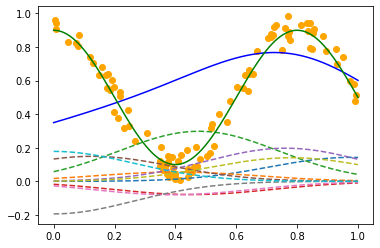

In [ ]:
# K = 10, learning rate = 0.01
k = 10
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

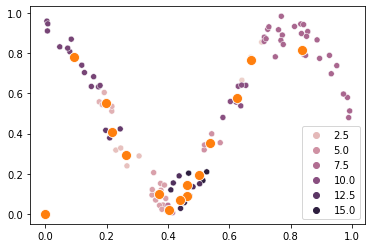

epoch 99, loss 0.05272161215543747


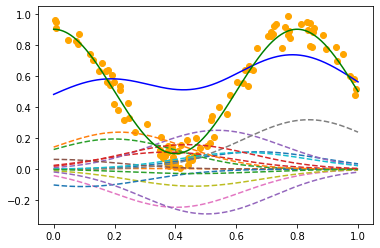

In [ ]:
# K = 15, learning rate = 0.01
k = 15
learning_rate = 0.01
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

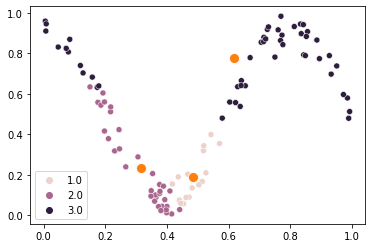

epoch 99, loss 0.04273701086640358


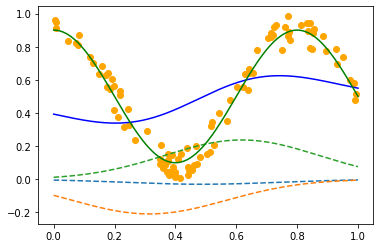

In [ ]:
# K = 3, learning rate = 0.02
k = 3
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

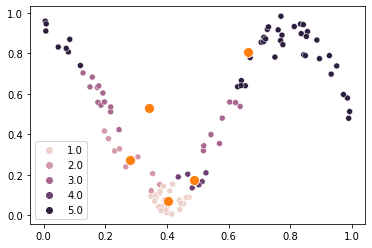

epoch 99, loss 0.014260842464864254


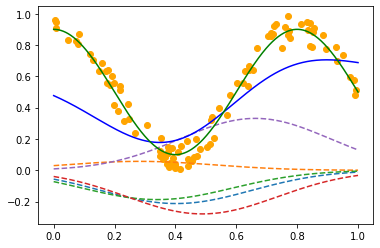

In [ ]:
# K = 5, learning rate = 0.02
k = 5
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

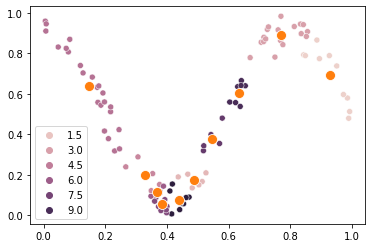

epoch 99, loss 0.016009951010346413


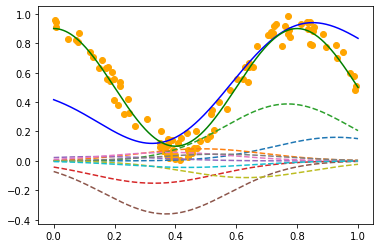

In [ ]:
# K = 10, learning rate = 0.02
k = 10
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

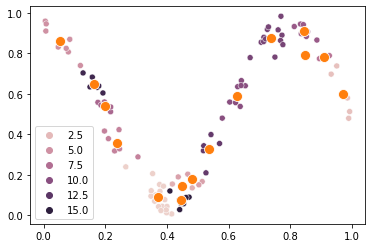

epoch 99, loss 0.02512587234377861


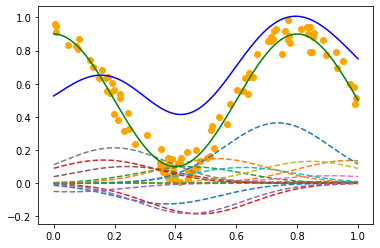

In [ ]:
# K = 15, learning rate = 0.02
k = 15
learning_rate = 0.02
cluster_centers, clusters = kmeans(k, data_array)
sns.scatterplot(x = data_array[0, :], y = data_array[1, :], hue = clusters)
sns.scatterplot(x = cluster_centers[0, :], y = cluster_centers[1, :], s = 100)
plt.show()
variance_list, gaussian_input, fixed_variance_list, fixed_gaussian_input = gaussian(k, cluster_centers, clusters)
weight, bias = LMS(k, learning_rate, fixed_gaussian_input)
draw(k, weight, bias, fixed_variance_list)

Comment on the comparative advantages of fixed-width and variable-width:
1. Fixed-width networks can also be arbitrarily well approximate linear combinations of Gaussian distributions with different widths.
2. Variable-width networks fit the characteristics of the data better, and provide more precise results.
3. Fixed-width can be calculated more easily.
